In [2]:
import glob
import os
import random

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from albumentations.pytorch import ToTensorV2
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm import tqdm

## Dataset Stats

In [ ]:
def calculate_dataset_stats(dataset_dir):
    sum_r = sum_g = sum_b = 0.0
    sum_sq_r = sum_sq_g = sum_sq_b = 0.0
    total_pixels = 0
    processed_files = 0
    problematic_files = []

    total_images = 0
    for class_dir in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_dir)
        if os.path.isdir(class_path):
            total_images += len([f for f in os.listdir(class_path) 
                               if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

    with tqdm(total=total_images, desc="Processing Images", 
             unit="img", dynamic_ncols=True) as pbar:
        
        for class_dir in os.listdir(dataset_dir):
            class_path = os.path.join(dataset_dir, class_dir)
            if not os.path.isdir(class_path):
                continue

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                
                if not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                    problematic_files.append(f"{img_path} - Not an image")
                    pbar.update(1)
                    continue
                
                try:
                    img = cv2.imread(img_path)
                    if img is None:
                        raise ValueError("OpenCV failed to read image")
                        
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    if img.dtype != np.uint8:
                        raise ValueError(f"Unexpected dtype: {img.dtype}")
                        
                    img = img.astype(np.float32) / 255.0
                    
                    sum_r += np.sum(img[:, :, 0])
                    sum_g += np.sum(img[:, :, 1])
                    sum_b += np.sum(img[:, :, 2])
                    
                    sum_sq_r += np.sum(np.square(img[:, :, 0]))
                    sum_sq_g += np.sum(np.square(img[:, :, 1]))
                    sum_sq_b += np.sum(np.square(img[:, :, 2]))
                    
                    total_pixels += img.shape[0] * img.shape[1]
                    processed_files += 1

                except Exception as e:
                    problematic_files.append(f"{img_path} - {str(e)}")
                
                finally:
                    pbar.update(1)
                    pbar.set_postfix({
                        'Processed': processed_files,
                        'Errors': len(problematic_files),
                        'Current': os.path.basename(class_dir)
                    })

    if total_pixels == 0:
        raise ValueError("No valid images processed - check dataset path or file formats")

    mean = [
        round(sum_r / total_pixels, 5),
        round(sum_g / total_pixels, 5),
        round(sum_b / total_pixels, 5)
    ]
    
    std = [
        round(np.sqrt((sum_sq_r / total_pixels) - (mean[0] ** 2)), 5),
        round(np.sqrt((sum_sq_g / total_pixels) - (mean[1] ** 2)), 5),
        round(np.sqrt((sum_sq_b / total_pixels) - (mean[2] ** 2)), 5)
    ]

    print("\nValidation Summary:")
    print(f"Total images attempted: {total_images}")
    print(f"Successfully processed: {processed_files}")
    print(f"Problematic files: {len(problematic_files)}")
    
    if problematic_files:
        print("\nFirst 5 errors:")
        for error in problematic_files[:5]:
            print(f" - {error}")

    return mean, std

In [ ]:
dataset_dir = 'Dataset'
mean, std = calculate_dataset_stats(dataset_dir)

dataset_mean = [round(float(m), 5) for m in mean]
dataset_std = [round(float(s), 5) for s in std]

print("\nDataset Statistics:")
print("Dataset Mean (RGB):", dataset_mean)
print("Dataset Std (RGB):", dataset_std)

assert all(0 <= m <= 1 for m in dataset_mean), "Mean values out of [0,1] range"
assert all(0 <= s <= 1 for s in dataset_std), "Std values out of [0,1] range"

assert abs(mean[0]*255 - 0.57119 * 255) < 0.1, "Red mean mismatch"
assert abs(mean[1]*255 - 0.57445 * 255) < 0.1, "Green mean mismatch"
assert abs(mean[2]*255 - 0.60537 * 255) < 0.1, "Blue mean mismatch"

assert abs(std[0]*255 - 0.11762 * 255) < 0.1, "Red std mismatch"
assert abs(std[1]*255 - 0.12342 * 255) < 0.1, "Green std mismatch"
assert abs(std[2]*255 - 0.11999 * 255) < 0.1, "Blue std mismatch"

print("\nBasic validation checks passed!")

In [3]:
dataset_mean = [0.57121, 0.57445, 0.60535]
dataset_std = [0.11756, 0.12333, 0.11987]

imageNet_mean = [0.485, 0.456, 0.406]
imageNet_std = [0.229, 0.224, 0.225]

## Traffic Sign Dataset

### Data Augmentation

In [4]:
transform_album = A.Compose(
    [   
        A.Resize(64, 64),
        A.Affine(
            translate_percent=0.02,
            scale=(0.95, 1.05),
            fill=128,
            p=0.3
        ),
        A.Perspective(
            scale=(0.05, 0.1),
            keep_size=True,
            fill=128,
            p=0.4
        ),
        # A.HueSaturationValue(
        #     hue_shift_limit=2,
        #     sat_shift_limit=3,
        #     val_shift_limit=3,
        #     p=0.2
        # ),
        A.RandomBrightnessContrast(
            brightness_limit=(0, 0.2),
            contrast_limit=0.1,
            p=0.2
        ),
        A.RGBShift(
          r_shift_limit=2,
          g_shift_limit=2,
          b_shift_limit=2,
          p=0.2 
        ),
        A.GaussianBlur(
            blur_limit=(3, 7),
            p=0.2
        ),
        A.GaussNoise(
            std_range=(0.01, 0.02),
            mean_range=(0.04, 0.06),
            p=0.2
        ),
        # A.CoarseDropout(
        #     num_holes_range=(1, 2),
        #     hole_height_range=(4, 6),
        #     hole_width_range=(4, 6),
        #     fill=128,
        #     p=0.2
        # ),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [5]:
transform_simple = A.Compose(
    [
        A.Resize(64, 64),
        A.Normalize(
            mean=tuple(dataset_mean),
            std=tuple(dataset_std)
        ),
        ToTensorV2()
    ],
    p=1
)

In [6]:
root_dir = r'Dataset'
output_dir = r'Augmented_Dataset'
os.makedirs(output_dir, exist_ok=True)

images_path_list = []
labels_path_list = []
class_idx = {}
augmentation_count = 5

class_names = sorted([d for d in os.listdir(root_dir)
                      if os.path.isdir(os.path.join(root_dir, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    images_tmp = os.path.join(root_dir, class_name, "*.png")
    images_paths = glob.glob(images_tmp)
    
    for img_path in images_paths:
        images_path_list.append(img_path)
        labels_path_list.append(cls_idx)

In [7]:
class_idx

{0: 'barred_area',
 1: 'cross_walk',
 2: 'go_straight',
 3: 'no_passing_zone_beginning',
 4: 'parking_zone',
 5: 'priority_over',
 6: 'steep_hill_downhill',
 7: 'steep_hill_uphill',
 8: 'stop',
 9: 'tunnel_beginning',
 10: 'turn_left',
 11: 'turn_right'}

In [38]:
pbar = tqdm(total=len(images_path_list) * augmentation_count, 
            desc="Augmenting Images", 
            unit="img", 
            dynamic_ncols=True)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    os.makedirs(class_dir, exist_ok=True)
    
    if not os.path.exists(class_dir):
        raise RuntimeError(f"Failed to create directory: {class_dir}")

for img_path in images_path_list:
    class_name = os.path.basename(os.path.dirname(img_path))
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    img = cv2.imread(img_path)
    if img is None:
        print(f"Warning: Could not read image {img_path}")
        pbar.update(augmentation_count)
        continue
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    base_name = os.path.splitext(os.path.basename(img_path))[0]
    
    for aug_num in range(1, augmentation_count + 1):
        transformed = transform_album(image=img)
        transformed_img = transformed['image']
        
        transformed_img = transformed_img.permute(1, 2, 0).numpy()
        transformed_img = (transformed_img * np.array(dataset_std) + np.array(dataset_mean))
        transformed_img = np.clip(transformed_img * 255, 0, 255).astype(np.uint8)
        
        new_filename = f"{base_name}_aug_{aug_num:02d}.png"
        new_path = os.path.join(output_dir, class_name, new_filename)
        
        if not os.path.exists(os.path.dirname(new_path)):
            os.makedirs(os.path.dirname(new_path), exist_ok=True)
        
        try:
            save_success = cv2.imwrite(new_path, cv2.cvtColor(transformed_img, cv2.COLOR_RGB2BGR))
            if not save_success:
                Image.fromarray(transformed_img).save(new_path)
                print(f"Used PIL fallback for {new_path}")
        except Exception as save_error:
            print(f"Failed to save {new_path}: {str(save_error)}")
            continue
        
        pbar.update(1)
        pbar.set_postfix_str(f"Processing: {class_name}/{new_filename}")

pbar.close()
output_files = glob.glob(os.path.join(output_dir, "**", "*.png"), recursive=True)
print(f"\nAugmentation complete. {len(images_path_list)} → {len(images_path_list)*augmentation_count} files")
print(f"Augmented images saved in: {os.path.abspath(output_dir)}")

Augmenting Images: 100%|██████████| 33595/33595 [03:17<00:00, 170.05img/s, Processing: turn_right/frame_0573_aug_05.png]               



Augmentation complete. 6719 → 33595 files
Augmented images saved in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Augmented_Dataset


In [10]:
images_path_list = []
for class_name in os.listdir(root_dir):
    class_path = os.path.join(root_dir, class_name)
    if os.path.isdir(class_path):
        images_path_list.extend(glob.glob(os.path.join(class_path, "*.png")))

pbar = tqdm(total=len(images_path_list), 
           desc="Processing Images", 
           unit="img", 
           dynamic_ncols=True)

for img_path in images_path_list:
    try:
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        
        transformed = transform_simple(image=img)
        processed_img = transformed['image']
        
        processed_img = processed_img.permute(1, 2, 0).numpy()
        processed_img = (processed_img * dataset_std + dataset_mean) * 255
        processed_img = processed_img.clip(0, 255).astype(np.uint8)
        
        cv2.imwrite(img_path, cv2.cvtColor(processed_img, cv2.COLOR_RGB2BGR))
        pbar.update(1)
        
    except Exception as e:
        print(f"\nError processing {img_path}: {str(e)}")
        continue

pbar.close()
print(f"\nProcessing complete. {len(images_path_list)} images replaced")
print(f"Original images overwritten in: {os.path.abspath(root_dir)}")

Processing Images: 100%|██████████| 6719/6719 [02:07<00:00, 52.65img/s]


Processing complete. 6719 images replaced
Original images overwritten in: c:\Users\tahaa\Documents\PythonProjects\MachineLearning\IKIUSelfDrivingCar\Dataset


### Dataset Class

In [8]:
class TrafficSignDB(Dataset):
    def __init__(self, images_path_list, labels_path_list, transform=None):
        self.images_path_list = images_path_list
        self.labels_path_list = labels_path_list
        self.transform = transform
        self.idx_to_class = self._create_label_mapping()
        
    def _create_label_mapping(self):
        return {idx: name for idx, name in enumerate(class_names)}
    
    def __len__(self):
        return len(self.images_path_list)
    
    def __getitem__(self, index):
        path = self.images_path_list[index]
        label = self.labels_path_list[index]
        
        try:
            image = cv2.imread(path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            if self.transform:
                if isinstance(self.transform, A.Compose):
                    # Albumentations Pipeline
                    augmented = self.transform(image=image)
                    image = augmented["image"]
                else:
                    # PyTorch PIL
                    image = Image.open(path).convert("RGB")
                    image = self.transform(image)
            else:
                image = ToTensorV2()(image=image)["image"]
            
        except Exception as e:
            print(f"Error processing image {path}: {e}")
            image = torch.zeros(3, 256, 256)
            
        return image, label
    
    def get_class_name(self, label_idx):
        return self.idx_to_class.get(label_idx, "unknown")

In [9]:
root_dir_dataset = r'Dataset'
root_dir_augmented = r'Augmented_Dataset'

train_percentage = 0.2

images_path_list_train = []
labels_path_list_train = []
images_path_list_test = []
labels_path_list_test = []
class_idx = {}

class_names = sorted([d for d in os.listdir(root_dir_dataset)
                      if os.path.isdir(os.path.join(root_dir_dataset, d))])

for cls_idx, class_name in enumerate(class_names):
    class_idx[cls_idx] = class_name
    
    # Augmented images (training)
    aug_pattern = os.path.join(root_dir_augmented, class_name, "*.png")
    aug_images_paths = glob.glob(aug_pattern)
    for img_path in aug_images_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)

    # Dataset images (training and testing)
    orig_pattern = os.path.join(root_dir_dataset, class_name, "*.png")
    orig_images_paths = sorted(glob.glob(orig_pattern))
    
    train_paths, test_paths = train_test_split(
        orig_images_paths,
        train_size=train_percentage,
        random_state=42,
        shuffle=True
    )
    
    for img_path in train_paths:
        images_path_list_train.append(img_path)
        labels_path_list_train.append(cls_idx)
        
    for img_path in test_paths:
        images_path_list_test.append(img_path)
        labels_path_list_test.append(cls_idx)

In [10]:
train_dataset = TrafficSignDB(
    images_path_list=images_path_list_train,
    labels_path_list=labels_path_list_train,
    transform=transform_simple
)

test_dataset = TrafficSignDB(
    images_path_list=images_path_list_test,
    labels_path_list=labels_path_list_test,
    transform=transform_simple
)

In [11]:
print("Class Mapping (idx -> class):")
print(train_dataset.idx_to_class)
print("\nTrain Dataset Files:")
for path, label in zip(images_path_list_train, labels_path_list_train):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")
print("\nTest Dataset Files:")
for path, label in zip(images_path_list_test, labels_path_list_test):
    print(f"Path: {path} | Label: {label} | Class: {class_names[label]}")

Class Mapping (idx -> class):
{0: 'barred_area', 1: 'cross_walk', 2: 'go_straight', 3: 'no_passing_zone_beginning', 4: 'parking_zone', 5: 'priority_over', 6: 'steep_hill_downhill', 7: 'steep_hill_uphill', 8: 'stop', 9: 'tunnel_beginning', 10: 'turn_left', 11: 'turn_right'}

Train Dataset Files:
Path: Augmented_Dataset\barred_area\frame_0001_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_03.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_04.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0001_aug_05.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_01.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_02.png | Label: 0 | Class: barred_area
Path: Augmented_Dataset\barred_area\frame_0002_aug_03.png | Label: 0 | Cla

In [12]:
batch_size = 32

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=4
)

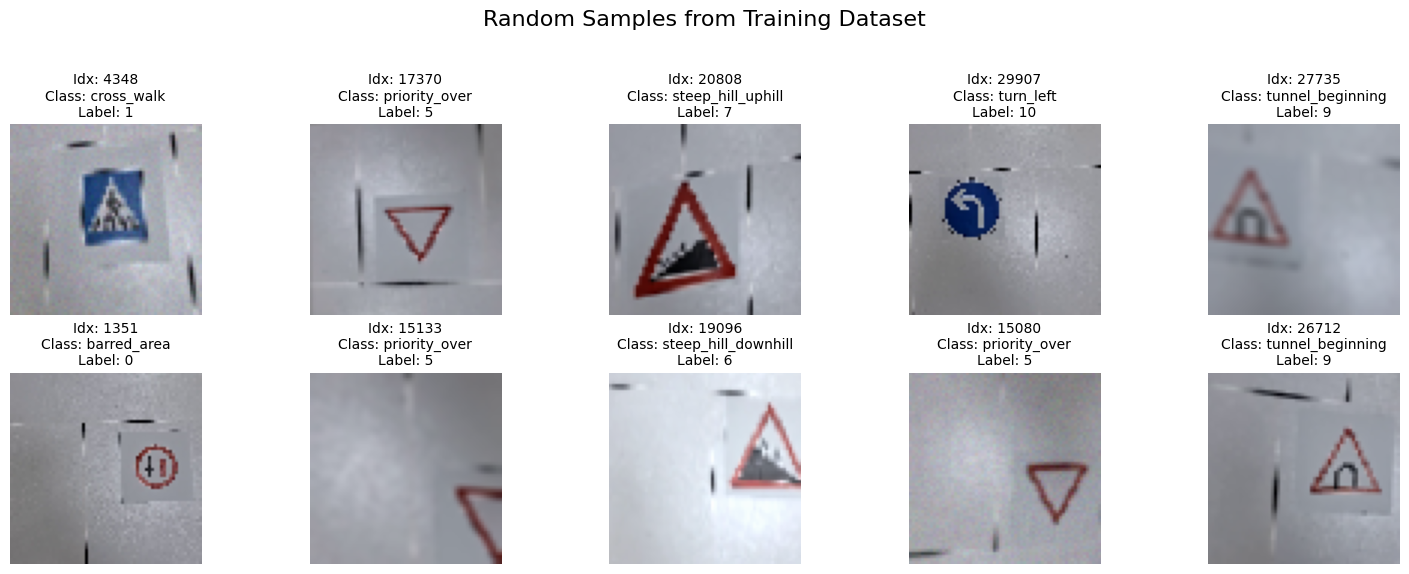

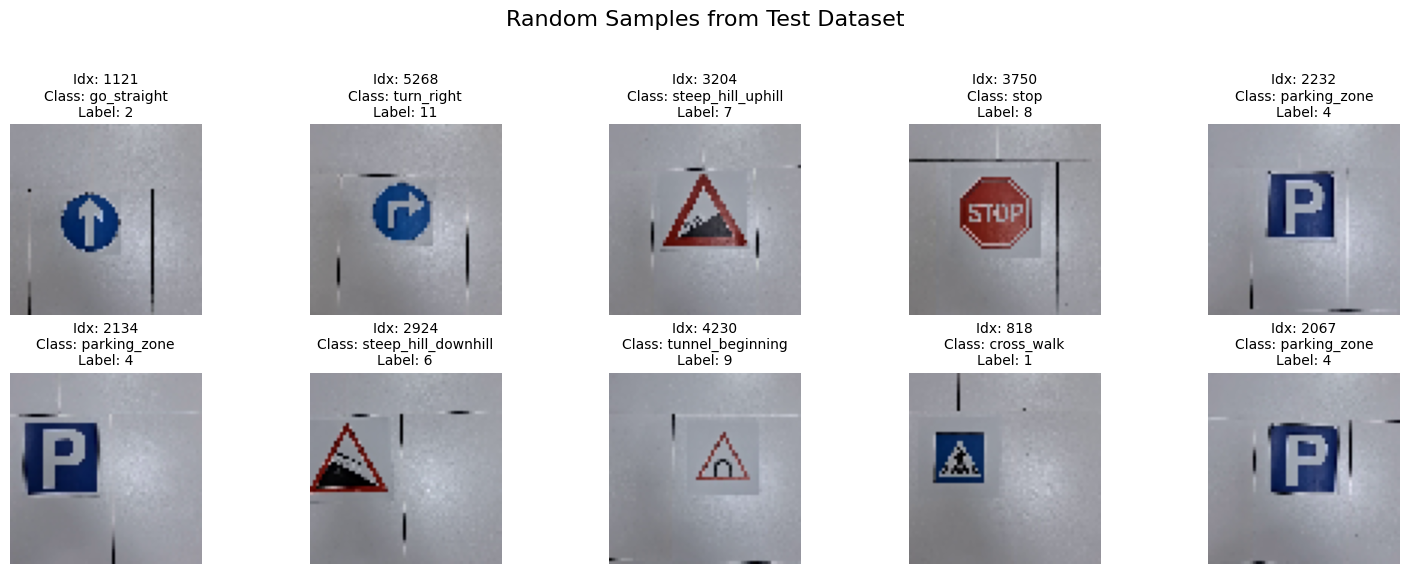

In [14]:
def denormalize_image(image_tensor, mean, std):
    image = image_tensor.cpu().numpy().transpose((1, 2, 0))
    mean = np.array(mean)
    std = np.array(std)
    image = image * std + mean
    image = np.clip(image, 0, 1)
    return image

def show_random_samples_subplot(dataset, num_samples=10, dataset_name="Dataset"):
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    axes = axes.flatten()
    
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        class_name = dataset.get_class_name(label)
        if isinstance(image, torch.Tensor):
            image = denormalize_image(image, dataset_mean, dataset_std)
        axes[i].imshow(image)
        axes[i].set_title(f"Idx: {idx}\nClass: {class_name}\nLabel: {label}", fontsize=10)
        axes[i].axis('off')
    
    plt.suptitle(f"Random Samples from {dataset_name}", fontsize=16)
    plt.tight_layout(rect=(0, 0.03, 1, 0.95), w_pad=2)
    plt.show()

show_random_samples_subplot(train_dataset, num_samples=10, dataset_name="Training Dataset")
show_random_samples_subplot(test_dataset, num_samples=10, dataset_name="Test Dataset")

## Training the Model

In [ ]:
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset

In [ ]:
class TrafficSignCNN(nn.Module):
    def __init__(self, num_classes=12):
        super(TrafficSignCNN, self).__init__()
        
        # self.model = models.resnet18(pretrained=True)
        
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 32 * 32, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, num_classes)

        self.dropout = nn.Dropout(0.5)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)

        x = self.relu(self.conv2(x))
        x = self.pool(x)

        x = self.relu(self.conv3(x))
        x = self.pool(x)

        x = x.view(x.size(0), -1)

        x = self.relu(self.fc1(x))
        x = self.dropout(x)

        x = self.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x

In [ ]:
train_loader = DataLoader(trafficSign_train, batch_size=32, shuffle=True, num_workers=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = TrafficSignCNN(num_classes=12)
model = model.to(device=device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_pred = 0
    total_pred = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        _, preds = torch.max(outputs, 1)
        correct_pred += torch.sum(preds == labels).item()
        total_pred += labels.size(0)
        
        running_loss += loss.item()
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct_pred / total_pred
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


torch.save(model.state_dict(), "traffic_sign_cnn.pth")

## Validation

In [ ]:
def load_model(model_path):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()
    return model.to(device)

In [ ]:
class_names = [
    'barred_area',
    'cross_walk',
    'go_straight',
    'no_passing_zone_beginning',
    'parking_zone',
    'priority_over',
    'steep_hill_downhill',
    'steep_hill_uphill',
    'stop',
    'tunnel_beginning',
    'turn_left',
    'turn_right'
]

In [ ]:
def live_test(model_path):
    # Load model
    model = TrafficSignCNN(num_classes=12)
    model.load_state_dict(torch.load(model_path))
    model.eval().to(device)
    
    # Define proper transforms
    transform = transforms.Compose([
        transforms.ToPILImage(),  # Convert numpy array to PIL first
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imageNet_mean, std=imageNet_std)
    ])
    
    cap = cv2.VideoCapture(0)
    
    while True:
        ret, frame = cap.read()
        if not ret: break
        
        # Convert to RGB and process
        rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        tensor_img = transform(rgb).unsqueeze(0).to(device)  # No 'image=' keyword
        
        # Inference
        with torch.no_grad():
            outputs = model(tensor_img)
            _, pred = torch.max(outputs, 1)
            sign_name = class_names[pred.item()]
        
        # Display
        cv2.putText(frame, sign_name, (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255,0), 2)
        cv2.imshow('Detection', frame)
        
        if cv2.waitKey(1) == ord('q'): break
    
    cap.release()
    cv2.destroyAllWindows()

In [ ]:
live_test("traffic_sign_cnn.pth")